In [16]:
import numpy as np
import pandas as pd
import quandl 
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
import torch
from torch import nn, optim
import pickle

In [2]:
quandl.ApiConfig.api_key = 'umQRdEcxaVzMFsfVPJ_y'
register_matplotlib_converters()

In [3]:
data = quandl.get('WIKI/AAPL')

In [4]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

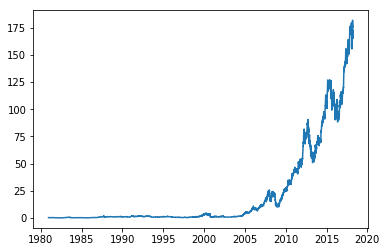

In [5]:
plt.plot(data['Adj. Close'])

In [25]:
batch_size = 64

In [74]:
dat = torch.tensor(data['Adj. Close'])
truncate_length = len(dat) - (int(len(dat) / 64) * 64)
dat = dat[truncate_length-1:]
x = dat[:-1] / max(dat)
y = dat[1:] / max(dat)
times = np.arange(len(y))

In [27]:
class lstm(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, batch_size, dropout):
        super(lstm, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, dropout=self.dropout)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x, hidden):
        x = x.reshape(self.batch_size, -1, self.input_dim)
        out, hidden = self.lstm(x)
        out.reshape(-1, self.hidden_dim)
        out = self.output(out)
        return(out, hidden)

In [69]:
model = lstm(input_dim=1, output_dim=1, hidden_dim=32, num_layers=2, batch_size=batch_size, dropout=0.7)
print(model)

lstm(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.7)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [71]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

In [29]:
f = open('/Users/js/programs/hidden.pckl', 'rb')
hidden = pickle.load(f)
f.close()

model = torch.load('/Users/js/programs/lstm-stock-time-series.pt')
model.eval()

lstm(
  (lstm): LSTM(1, 16, batch_first=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

0.046946968883275986


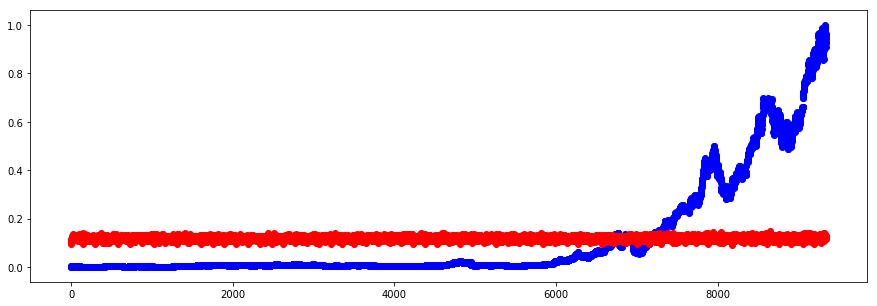

In [ ]:
epochs = 500
show_every = 100

model.train()
for e in range(epochs):
    model.zero_grad()
    prediction, hidden = model(x, hidden)
    loss = loss_fn(prediction, y)
    loss.backward()
    optimizer.step()
    if (e+1) % show_every == 0:
        print(loss.item())
        plt.figure(figsize=(15, 5))
        prediction = prediction.reshape(-1, 1)
        prediction = prediction.detach().numpy()
        plt.scatter(times, y.reshape(-1, 1), color='b')
        plt.scatter(times, prediction, color='r')
        plt.show()

0.055939555168151855


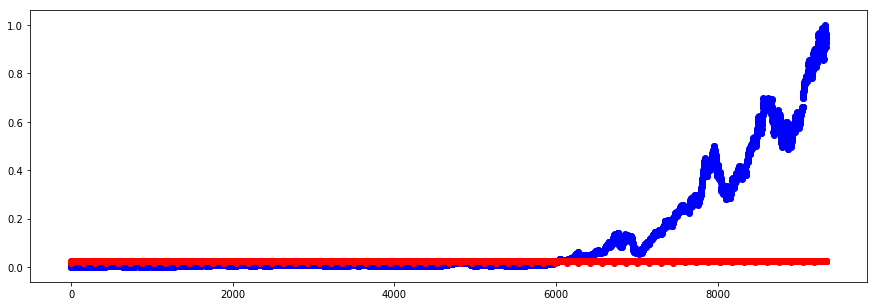

In [76]:
model.eval()
prediction, hidden = model(x, hidden)
loss = loss_fn(prediction, y)
print(loss.item())
plt.figure(figsize=(15, 5))
prediction = prediction.reshape(-1, 1)
prediction = prediction.detach().numpy()
plt.scatter(times, y.reshape(-1, 1), color='b')
plt.scatter(times, prediction, color='r')
plt.show()